In [1]:
% load_ext rpy2.ipython

In [102]:
%%R
library(phyloseq)
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)


In [5]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [43]:
%%R
sample_data(physeq)$Trtmt==

 [1] "Blank"          "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"  
 [5] "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"  
 [9] "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"  
[13] "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"  
[17] "Ferrihydrite"   "Ferrihydrite"   "Ferrihydrite"   "Heavy Fraction"
[21] "Heavy Fraction" "Heavy Fraction" "Kaolinite"      "Kaolinite"     
[25] "Kaolinite"      "Kaolinite"      "Kaolinite"      "Kaolinite"     
[29] "Kaolinite"      "Kaolinite"      "Kaolinite"      "Kaolinite"     
[33] "Kaolinite"      "Kaolinite"      "Kaolinite"      "Kaolinite"     
[37] "Kaolinite"      "Kaolinite"      "Kaolinite"      "Quartz"        
[41] "Quartz"         "Quartz"         "Quartz"         "Quartz"        
[45] "Quartz"         "Quartz"         "Quartz"         "Quartz"        
[49] "Quartz"         "Quartz"         "Quartz"         "Quartz"        
[53] "Quartz"         "Quartz"         "Quartz"    

In [44]:
%%R
ps.FQS = subset_samples(physeq, (sample_data(physeq)$Trtmt=="Ferrihydrite"|sample_data(physeq)$Trtmt=="Quartz"|sample_data(physeq)$Trtmt=="Soil"))

In [45]:
%%R
physeq.noSmall<-subset_samples(ps.FQS,sample_sums(physeq)>2000)

In [46]:
%%R
ps <- physeq.noSmall

In [47]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [106]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3, trymax=40)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1620361 
Run 1 stress 0.158892 
... New best solution
... procrustes: rmse 0.04559772  max resid 0.3042682 
Run 2 stress 0.1633461 
Run 3 stress 0.1588805 
... New best solution
... procrustes: rmse 0.000954739  max resid 0.005265447 
*** Solution reached


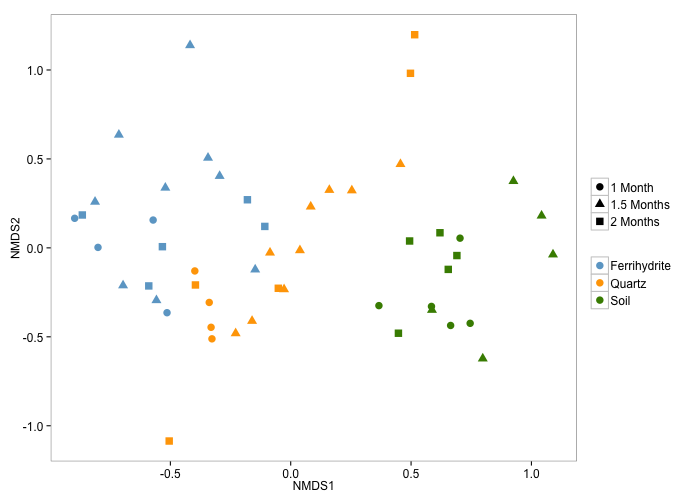

In [107]:
%%R -h 500 -w 700
#D <- ord.full.plot
# Sets the relevant ordination

#colnames(D)[1:2]<-c("Axis1","Axis2")
# Renames the axis columns

#D$Month<-as.factor(D$Month)
#D$Cosm<-as.factor(D$Cosm)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"1.5 Months","2 Months"))

p = plot_ordination(ps_snorm, ord.full, color = "Trtmt", shape = "MonthName")

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","orange","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
      #legend.position = "bottom"
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

#p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [105]:
%%R
ggsave(filename="NMDS.jpg", plot=p ,width=7, height=5)

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.